In [4]:
%pip install soxr

Note: you may need to restart the kernel to use updated packages.


In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
# basic algebra and system libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as path
import pandas as pd
import gc
# signal discrete fourier transform and loading
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import scipy.fft as fft
# audio preprocessing, cross validation and others
from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score
# construction of convolutional neural network
import keras
import keras.optimizers as optimizers
import keras.layers as layers
import keras.losses as losses
import keras.metrics as metrics
import keras.regularizers as regularizers
# audio analysis
import librosa
import librosa.display
# processing speedup using gpu
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# allow gpu computation to exceed system memory for a certain amount
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

Dataset from: https://www.kaggle.com/datasets/emanuelbuttaci/audios/data

In [6]:
metadata = pd.read_csv('dataset/metadata.csv')
audios = [ wavfile.read(path.join(audio_path)) for audio_path in metadata['path'] ]
metadata['rate'] = [ sample_rate for sample_rate, _ in audios ]
metadata['signal'] = [ wave for _, wave in audios ]
metadata['target'] = metadata['action'] + metadata['object']

## Preprocessing <a name="p2"></a>

In [7]:
class AudioPreprocessor(TransformerMixin):
    def __init__(self, sr: int = 16000) -> None:
        self.sr = sr

    def fit(self, X, y = None, **params):
        X_resampled = X.copy()
        # first resample to target frequency 16000
        X_resampled['signal'] = [ librosa.resample(signal / 32768, orig_sr = rate, target_sr = self.sr, res_type = 'soxr_qq') if rate != self.sr else (signal / 32768) for rate, signal in zip(X_resampled['rate'], X_resampled['signal']) ]
        # expect X to be full dataset with signal column holding wave signal arrays
        # learn fixed count of samples from trimmed wave signals
        trimmed = [ librosa.effects.trim(audio, top_db = 20)[0] for audio in X_resampled['signal'].values ]
        # take 95% percentile to compute the chosen length for all recordings
        self.samples = int(np.percentile([ audio.shape[0] - np.argmin((audio == 0)[::-1]) for audio in trimmed ], 95))

        return self

    def transform(self, X, y = None, **params):
        X_resampled = X.copy()
        # first resample to target frequency 16000
        X_resampled['signal'] = [ librosa.resample(signal / 32768, orig_sr = rate, target_sr = self.sr, res_type = 'soxr_qq') if rate != self.sr else (signal / 32768) for rate, signal in zip(X_resampled['rate'], X_resampled['signal']) ]
        # trim and pad wave files
        trimmed = [ librosa.effects.trim(audio, top_db = 20)[0] for audio in X_resampled['signal'].values ]
        waves = np.stack([ audio[:self.samples] if audio.shape[0] >= self.samples else np.pad(audio, (0, self.samples - audio.shape[0]), constant_values = (0, 0)) for audio in trimmed ], axis = 0)
        # result is wave signals with corresponding indexes
        return waves

## Model construction <a name="p3"></a>


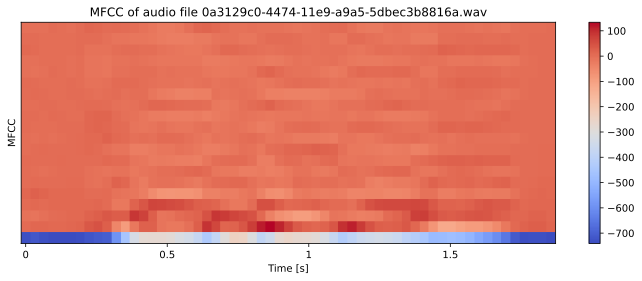

In [8]:
class MFCC(TransformerMixin):
    # Extracts Mel-cepstral coefficients from audio signals
    def __init__(self, sr: int = 16000) -> None:
        self.sr = sr

    def fit(self, X, y = None, **params):
        return self

    def transform(self, X, y = None, **params):
        # extraction of MFCC, which results in
        # a matrix (128, 20) for each audio signal
        coefficients = [
            librosa.feature.mfcc(
                y = x,
                sr = self.sr,
                n_mfcc = 20,
                n_fft = 2048,
                hop_length = 512,
                n_mels = 128
            )
            for x in X
        ]
        # one unitary dimension is added to make data format
        # compatible with respect to keras input
        return np.expand_dims(coefficients, axis = -1)

# let us show a MFCC matrix from the first audio
audio_id = 0
mfcc = librosa.feature.mfcc(
    y = metadata.loc[audio_id, 'signal'] / 32768,
    sr = metadata.loc[audio_id, 'rate'],
    n_mfcc = 20,
    n_fft = 2048,
    hop_length = 512,
    n_mels = 128
)
# visualize spectrogram as image
plt.figure(figsize = (12, 4))
librosa.display.specshow(mfcc, sr = metadata.loc[audio_id, 'rate'], x_axis = 'time')
plt.colorbar()
plt.title(f"MFCC of audio file {os.path.basename(metadata.loc[audio_id, 'path'])}")
plt.xlabel('Time [s]')
plt.ylabel('MFCC')
plt.show()

In [9]:
def create_convolutional_neural_network(input_shape, n_classes):
    # sequence of layers
    model = keras.Sequential([
        # input shape is the one of (n_mels, n_frames) from MFCC matrix
        layers.Input(input_shape),
        # gaussian noise has 0 mean and 0.1 standard deviation and it is
        # used to generalize better the model and avoid overfitting
        layers.GaussianNoise(0.1),
        # first convolutional layer, which employes ReLU activation,
        # batch normalization to rescale data before next input, dropout
        # to avoid overfitting and max pooling
        layers.Conv2D(32, (3, 3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.MaxPooling2D((2, 2)),
        # second convolutional layer to reduce dimensionality
        layers.Conv2D(64, (3, 3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.MaxPooling2D((2, 2)),
        # this layer will transform data from 2D format to 1D array
        layers.Flatten(),
        # fully connected layer using ReLU activation, normalization and dropout
        layers.Dense(128, activation = 'relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        # output layer which uses softmax activation
        layers.Dense(n_classes, activation = 'softmax')
    ])
    # model is optimized using adaptive moment estimation optimizer and categorical
    # cross entropy as loss function, where label is ordinal encoded and not one hot
    # encoded
    # accuracy is used as evaluation metric at each epoch
    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = [ 'accuracy' ],
    )
    # final model is returned
    return model

class ConvolutionalNeuralNetwork(BaseEstimator, ClassifierMixin):
    def __init__(self, n_classes: int):
        self.n_classes = n_classes

    def get_params(self, deep = True):
        return { 'n_classes': self.n_classes }

    def set_params(self, **params):
        self.n_classes = params['n_classes']
        return self

    def fit(self, X, y, **params):
        # classes
        classes = list(range(self.n_classes))
        # create cnn model
        self.model_ = create_convolutional_neural_network(
            input_shape = X.shape[1:],
            n_classes = self.n_classes
        )
        # fit model
        self.model_.fit(
            X,
            y,
            batch_size = 64,
            class_weight = dict(zip(classes, class_weight.compute_class_weight('balanced', classes = classes, y = y))),
            epochs = 250,
            use_multiprocessing = True,
            verbose = 0
        )

        return self

    def predict(self, X, y = None, **params):
        return np.argmax(self.model_.predict(X), axis = 1)

In [10]:
# preprocessing and feature extraction on whole dataset
preprocessing = Pipeline([
    ('audio_preprocessor', AudioPreprocessor(sr = 16000)),
    ('feature_extractor', MFCC(sr = 16000))
])
# label encoding
encoder = LabelEncoder()
# transform input and output
y = encoder.fit_transform(metadata['target'])
X = preprocessing.fit_transform(metadata)
print(f'Shape of input is {X.shape}')
# cross validation
scores = cross_val_score(
    ConvolutionalNeuralNetwork(n_classes = len(encoder.classes_)),
    X,
    y,
    cv = 5,
    scoring = 'accuracy'
)
# dump average score
print(f'ConvolutionalNeuralNetwork: {np.mean(scores)} ± {np.std(scores)}')

Shape of input is (9854, 20, 61, 1)





62/62 [==============================] - 1s 6ms/step
ConvolutionalNeuralNetwork: 0.809615464849454 ± 0.02737021731736542


In [11]:
# Save the trained model
model = ConvolutionalNeuralNetwork(n_classes = len(encoder.classes_))
model.fit(X, y)
model_path = './trained_model.h5'
model.model_.save(model_path)
print(f'Model saved to {model_path}')

e:\UMB\4\Machine Learning_1B6152BF\TB2\program\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to ./trained_model.h5


-------------------------------------------------------------
Recording...
-------------------------------------------------------------
Recording finished
-------------------------------------------------------------
1/1 [==============================] - 0s 132ms/step


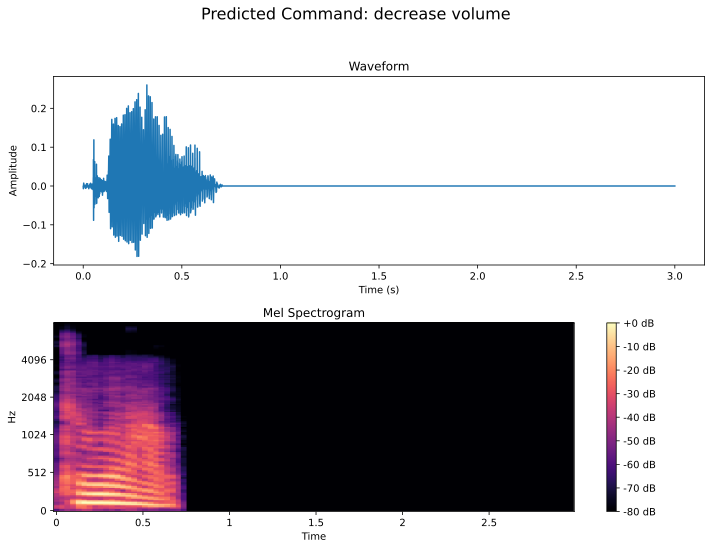

-------------------------------------------------------------
Predicted command: decrease volume
-------------------------------------------------------------


In [7]:
import sounddevice as sd
import pandas as pd
from scipy.io.wavfile import write
from keras.models import load_model

# Function to record audio from the microphone
def record_audio(duration=3, fs=16000, output_file='output.wav'):
    os.system('cls')
    print("-------------------------------------------------------------")
    print("Recording...")
    print("-------------------------------------------------------------")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='int16')
    sd.wait()  # Wait until recording is finished
    write(output_file, fs, recording)  # Save as WAV file
    print("Recording finished")
    print("-------------------------------------------------------------")
    return output_file

# Function to plot waveform and spectrogram in one figure
def plot_waveform_and_spectrogram(signal, sr, predicted_word):
    plt.figure(figsize=(10, 8))

    # Plot waveform
    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, len(signal) / sr, num=len(signal)), signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform')

    # Plot spectrogram
    plt.subplot(2, 1, 2)
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')

    # Set overall title
    plt.suptitle(f'Predicted Command: {predicted_word}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Function to load and preprocess audio
def load_and_preprocess_audio(file_path, sr=16000):
    rate, signal = wavfile.read(file_path)
    signal = librosa.resample(signal / 32768, orig_sr=rate, target_sr=sr, res_type='soxr_qq')
    trimmed = librosa.effects.trim(signal, top_db=20)[0]
    
    # Define signal length
    desired_samples = sr * 3  # 3 seconds
    
    if len(trimmed) < desired_samples:
        signal = np.pad(trimmed, (0, desired_samples - len(trimmed)), 'constant')
    else:
        signal = trimmed[:desired_samples]
    
    # Count MFCC
    n_mfcc = 20
    n_fft = 2048
    hop_length = 512
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    
    expected_frames = 61
    if mfcc.shape[1] < expected_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, expected_frames - mfcc.shape[1])), 'constant')
    else:
        mfcc = mfcc[:, :expected_frames]
    
    return signal, np.expand_dims(np.expand_dims(mfcc, axis=-1), axis=0)

# Load the trained model
model_path = './trained_model.h5'
model = load_model(model_path)

# Load the metadata to fit the LabelEncoder
metadata = pd.read_csv('dataset/metadata.csv')
metadata['target'] = metadata['action'] + ' ' + metadata['object']

# Label encoder
encoder = LabelEncoder()
encoder.fit(metadata['target'])

# Mapping from label to word
labels_to_words = {i: word for i, word in enumerate(encoder.classes_)}

# Function to predict from microphone input
def predict_from_mic(duration=3, sr=16000):
    audio_file = record_audio(duration, sr)
    signal, input_data = load_and_preprocess_audio(audio_file, sr)
    prediction = model.predict(input_data)
    predicted_label = np.argmax(prediction, axis=1)[0]
    predicted_word = labels_to_words.get(predicted_label, "Unknown")
    predicted_word = predicted_word.replace("none", "").strip()

    # Plot waveform and spectrogram with predicted word
    plot_waveform_and_spectrogram(signal, sr, predicted_word)

    return predicted_word

# usage
predicted_word = predict_from_mic()
print("-------------------------------------------------------------")
print(f"Predicted command: {predicted_word}")
print("-------------------------------------------------------------")
